In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import vizro.plotly.express as px
from vizro import Vizro
import vizro.models as vm
from tqdm import trange

# Get overall engagement data

In [2]:
# Set seed
np.random.seed(15072)

# Read in data
smb_raw = pd.read_excel('smb_restaurants.xlsx', sheet_name='dataset')
smb_raw

,business_name,insta_link,insta_followers,insta_ave_views_first5_biz_202309,insta_ave_likes_first5_biz_202309,insta_ave_comments_first5_biz_202309,insta_ave_views_first5_biz_202308,insta_ave_likes_first5_biz_202308,insta_ave_comments_first5_biz_202308,insta_ave_views_first5_biz_202307,...,tiktok_ave_comments_first5_nonbiz_202307,tiktok_ave_views_first5_nonbiz_202306,tiktok_ave_likes_first5_nonbiz_202306,tiktok_ave_comments_first5_nonbiz_202306,tiktok_ave_views_first5_nonbiz_202305,tiktok_ave_likes_first5_nonbiz_202305,tiktok_ave_comments_first5_nonbiz_202305,tiktok_ave_views_first5_nonbiz_202304,tiktok_ave_likes_first5_nonbiz_202304,tiktok_ave_comments_first5_nonbiz_202304
0,Cafe Luna,https://www.instagram.com/cafelunacentralsq/,3160,na,na,na,na,na,na,na,...,4,1821.666667,35.5,3,3020,134,3,0,0,0
1,Moona,https://www.instagram.com/moonarestaurant/,6882,na,50.5,1,na,70,5,na,...,0,18484,1112,10,968,40,5,63700,2569,52
2,4 Corners Pizza,https://www.instagram.com/4cornerspizza/,27000,13548,424,47,23624.5,1096.5,23,29607.66667,...,24.5,16813.5,405.2,3,25633.5,4121,22,1402,43,1.5
3,Hunters,https://www.instagram.com/huntersboston/,21000,12321,256,4.6,7276,260.2,2.6,na,...,0,2212,129.5,1,566,31,1,378.8,12,0.4
4,Ruka Resto Bar,https://www.instagram.com/rukarestobar/,12000,4897,157.4,1.4,2701,118.4,1.8,3869,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Crudo Boston,https://www.instagram.com/crudoboston/,1854,na,na,na,na,na,na,na,...,na,na,na,na,na,na,na,536,20,0
96,Meimei dumplings,https://www.instagram.com/meimeidumplings/,25000,na,439.2,13.2,na,549.4,4,na,...,na,na,na,na,na,na,na,na,na,na
97,Paramount Southie,https://www.instagram.com/paramountsouthie/,3032,na,na,0,na,na,na,na,...,na,na,na,na,na,na,na,na,na,na
98,Teado Central,https://www.instagram.com/teadocentral/,104,na,na,na,na,na,na,na,...,na,na,na,na,na,na,na,na,na,na


In [3]:
# Preprocessing
smb = smb_raw.replace('na', np.nan)
# Assuming your DataFrame is df
smb.fillna(0, inplace=True)
print(smb)
print(smb.dtypes)

        business_name                                    insta_link  \
0           Cafe Luna  https://www.instagram.com/cafelunacentralsq/   
1               Moona    https://www.instagram.com/moonarestaurant/   
2     4 Corners Pizza      https://www.instagram.com/4cornerspizza/   
3             Hunters      https://www.instagram.com/huntersboston/   
4      Ruka Resto Bar       https://www.instagram.com/rukarestobar/   
..                ...                                           ...   
95       Crudo Boston        https://www.instagram.com/crudoboston/   
96   Meimei dumplings    https://www.instagram.com/meimeidumplings/   
97  Paramount Southie   https://www.instagram.com/paramountsouthie/   
98      Teado Central       https://www.instagram.com/teadocentral/   
99       Trade Boston        https://www.instagram.com/tradeboston/   

    insta_followers  insta_ave_views_first5_biz_202309  \
0            3160.0                                0.0   
1            6882.0            

In [4]:
# Update data types
data_types = {'business_name': 'string', 'insta_link': 'string', 'insta_name': 'string'}
smb = smb.astype(data_types)
print(smb.dtypes)

business_name                               string[python]
insta_link                                  string[python]
insta_followers                                    float64
insta_ave_views_first5_biz_202309                  float64
insta_ave_likes_first5_biz_202309                  float64
                                                 ...      
tiktok_ave_likes_first5_nonbiz_202305              float64
tiktok_ave_comments_first5_nonbiz_202305           float64
tiktok_ave_views_first5_nonbiz_202304              float64
tiktok_ave_likes_first5_nonbiz_202304              float64
tiktok_ave_comments_first5_nonbiz_202304           float64
Length: 83, dtype: object


In [5]:
print(smb.columns)

Index(['business_name', 'insta_link', 'insta_followers',
       'insta_ave_views_first5_biz_202309',
       'insta_ave_likes_first5_biz_202309',
       'insta_ave_comments_first5_biz_202309',
       'insta_ave_views_first5_biz_202308',
       'insta_ave_likes_first5_biz_202308',
       'insta_ave_comments_first5_biz_202308',
       'insta_ave_views_first5_biz_202307',
       'insta_ave_likes_first5_biz_202307',
       'insta_ave_comments_first5_biz_202307',
       'insta_ave_views_first5_biz_202306',
       'insta_ave_likes_first5_biz_202306',
       'insta_ave_comments_first5_biz_202306',
       'insta_ave_views_first5_biz_202305',
       'insta_ave_likes_first5_biz_202305',
       'insta_ave_comments_first5_biz_202305',
       'insta_ave_views_first5_biz_202304',
       'insta_ave_likes_first5_biz_202304',
       'insta_ave_comments_first5_biz_202304', 'fb_link', 'fb_followers',
       'fb_ave_views_first5_biz_202309', 'fb_ave_likes_first5_biz_202309',
       'fb_ave_comments_first5_

## EDA: Get stacked cols of likes, comments and views for each platform

In [6]:
# Drop rows of a df that are all 0s
def drop_zero_rows(df):
    return df.loc[~(df==0).all(axis=1)]

# Get stacked columns of monthly likes, comments, and views
def get_stacked_cols(smb, platform):
    # Create dfs containing only columns with likes, comments, or views
    # Stack the columns together
    # Drop rows that are all 0s
    likes_columns = drop_zero_rows(smb.filter(like=f'{platform}_ave_likes_first5_biz').filter(regex='^(?!.*quartile).*$')).stack().reset_index(drop=True)
    comments_columns = drop_zero_rows(smb.filter(like=f'{platform}_ave_comments_first5_biz').filter(regex='^(?!.*quartile).*$')).stack().reset_index(drop=True)
    views_columns = drop_zero_rows(smb.filter(like=f'{platform}_ave_views_first5_biz').filter(regex='^(?!.*quartile).*$')).stack().reset_index(drop=True)

    return likes_columns, comments_columns, views_columns

In [7]:
likes_columns_insta, comments_columns_insta, views_columns_insta = get_stacked_cols(smb, 'insta')
likes_columns_fb, comments_columns_fb, views_columns_fb = get_stacked_cols(smb, 'fb')
likes_columns_tiktok, comments_columns_tiktok, views_columns_tiktok = get_stacked_cols(smb, 'tiktok')
likes_columns_insta

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
511    39.0
512    50.6
513    47.5
514    33.6
515    40.0
Length: 516, dtype: float64

In [8]:
def plot_hist(fb, insta, tiktok, log, metric):
    plt.figure(figsize=(6,4))
    if log:
        fb = np.log(fb+1)
        insta = np.log(insta+1)
        tiktok = np.log(tiktok+1)
    plt.hist(fb, label='fb', alpha=0.5, bins=20)
    plt.hist(insta, label='insta', alpha=0.5, bins=20)
    plt.hist(tiktok, label='tiktok', alpha=0.5, bins=20)
    plt.title(metric)
    plt.legend()
    plt.show()

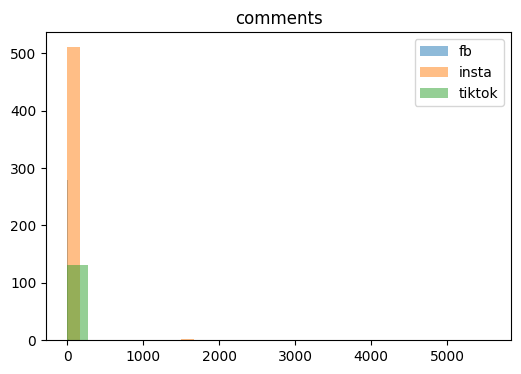

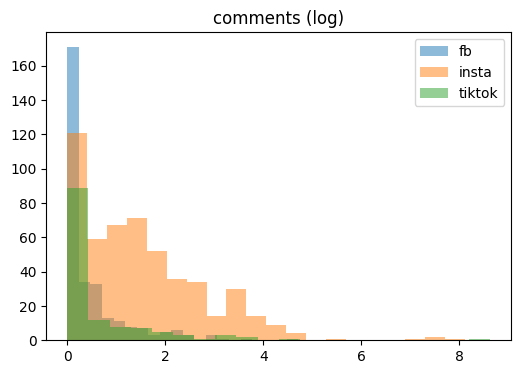

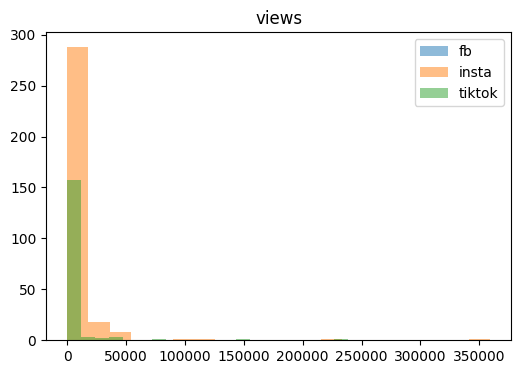

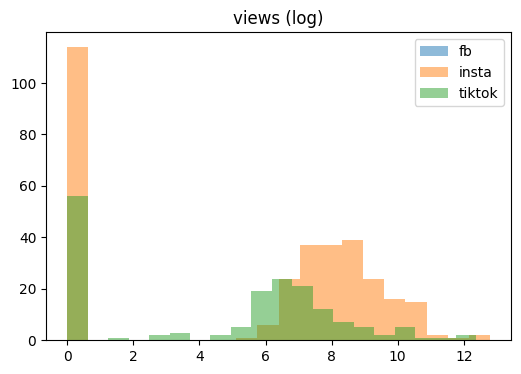

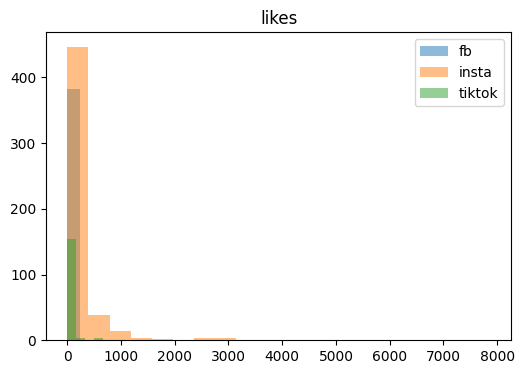

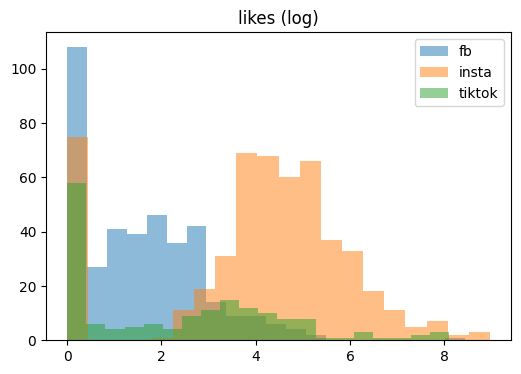

In [9]:
plot_hist(comments_columns_fb, comments_columns_insta, comments_columns_tiktok, log=False, metric='comments')
plot_hist(comments_columns_fb, comments_columns_insta, comments_columns_tiktok, log=True, metric='comments (log)')
plot_hist(views_columns_fb, views_columns_insta, views_columns_tiktok, log=False, metric='views')
plot_hist(views_columns_fb, views_columns_insta, views_columns_tiktok, log=True, metric='views (log)')
plot_hist(likes_columns_fb, likes_columns_insta, likes_columns_tiktok, log=False, metric='likes')
plot_hist(likes_columns_fb, likes_columns_insta, likes_columns_tiktok, log=True, metric='likes (log)')

## Get overall engagement for each platform

In [10]:
# Get total number of likes and views for insta and tiktok
tiktok_likes = drop_zero_rows(smb.filter(like=f'tiktok_ave_likes_first5_biz')).stack().reset_index(drop=True).sum()
insta_likes = drop_zero_rows(smb.filter(like=f'insta_ave_likes_first5_biz')).stack().reset_index(drop=True).sum()
fb_likes = drop_zero_rows(smb.filter(like=f'fb_ave_likes_first5_biz')).stack().reset_index(drop=True).sum()
tiktok_views = drop_zero_rows(smb.filter(like=f'tiktok_ave_views_first5_biz')).stack().reset_index(drop=True).sum()
insta_views = drop_zero_rows(smb.filter(like=f'insta_ave_views_first5_biz')).stack().reset_index(drop=True).sum()

tiktok_view_to_like_ratio = tiktok_views/tiktok_likes
insta_view_to_like_ratio = insta_views/insta_likes
fb_view_to_like_ratio = 0.5*(tiktok_views/tiktok_likes+insta_views/insta_likes)

print("Tiktok view to like ratio:", tiktok_view_to_like_ratio)
print("Insta view to like ratio:", insta_view_to_like_ratio)
print("Estimated FB view to like ratio:", fb_view_to_like_ratio)

Tiktok view to like ratio: 40.15629141323766
Insta view to like ratio: 18.420619974741825
Estimated FB view to like ratio: 29.288455693989743


In [11]:
def get_overall_engagement(smb, platform, fb_view_to_like_ratio):
    months = ['202304', '202305', '202306', '202307', '202308', '202309']
    # metrics = ['likes', 'comments', 'views']
    
    overall_engagement_stacked = pd.DataFrame()
    for month in months:
        # Get the views, likes and comments for a specific (platform, month)
        views = f'{platform}_ave_views_first5_biz_{month}'
        likes = f'{platform}_ave_likes_first5_biz_{month}'
        comments = f'{platform}_ave_comments_first5_biz_{month}'
        df_month_platform = smb[[views, likes, comments]]

        # Calculate the overall engagement for a platform in a specific month
        # log(views + 5*likes + 10*comments + 1) for insta and tiktok which have views, likes and comments
        if platform != 'fb':
            overall_engagement = np.log(df_month_platform[views] + 5*df_month_platform[likes] + 10*df_month_platform[comments] + 1)
        # log(fb_view_to_like_ratio*likes + 5*likes + 10*comments + 1) for fb which has likes and comments but no views
        else:
            overall_engagement = np.log(fb_view_to_like_ratio * df_month_platform[likes] + 5*df_month_platform[likes] + 10*df_month_platform[comments] + 1)

        # For a platform, concat the overall engagement across different months
        overall_engagement_stacked = pd.concat([overall_engagement_stacked, overall_engagement], axis=1)

    # Drop rows that are all 0s
    overall_engagement_stacked = drop_zero_rows(overall_engagement_stacked)
    # Stack the columns together
    overall_engagement_stacked = pd.DataFrame(overall_engagement_stacked.stack().reset_index(drop=True), columns=['overall_engagement'])

    return overall_engagement_stacked

In [12]:
overall_engagement_fb = get_overall_engagement(smb, 'fb', fb_view_to_like_ratio)
overall_engagement_insta = get_overall_engagement(smb, 'insta', fb_view_to_like_ratio)
overall_engagement_tiktok = get_overall_engagement(smb, 'tiktok', fb_view_to_like_ratio)
overall_engagement_tiktok


,overall_engagement
0,6.900731
1,0.000000
2,7.374002
3,10.329605
4,0.000000
...,...
163,3.672072
164,3.791737
165,5.609472
166,0.000000


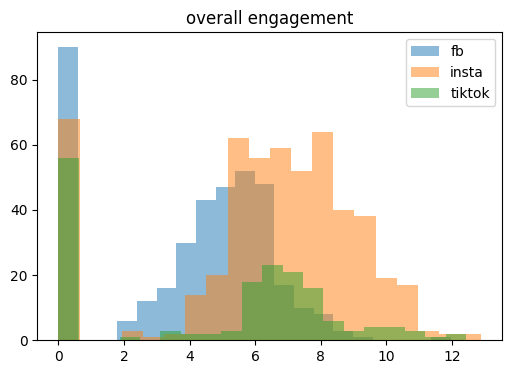

In [13]:
plot_hist(overall_engagement_fb, overall_engagement_insta, overall_engagement_tiktok, log=False, metric='overall engagement')

# Get overall engagement statistics (quantiles, SD)

In [14]:
# Split overall engagement into 4 or 3 quantiles, depending on the platform
overall_engagement_fb['quantile'] = pd.qcut(overall_engagement_fb['overall_engagement'], 4, labels=False)
overall_engagement_insta['quantile'] = pd.qcut(overall_engagement_insta['overall_engagement'], 4, labels=False)
overall_engagement_tiktok['quantile'] = pd.qcut(overall_engagement_tiktok['overall_engagement'], 3, labels=False)
overall_engagement_tiktok

,overall_engagement,quantile
0,6.900731,1
1,0.000000,0
2,7.374002,2
3,10.329605,2
4,0.000000,0
...,...,...
163,3.672072,1
164,3.791737,1
165,5.609472,1
166,0.000000,0


In [15]:
# Also get the intervals / quantiles
overall_engagement_quantiles_fb = pd.DataFrame(overall_engagement_fb.groupby('quantile')['overall_engagement'].agg(['min', 'max']).reset_index()['min'])
overall_engagement_quantiles_insta = pd.DataFrame(overall_engagement_insta.groupby('quantile')['overall_engagement'].agg(['min', 'max']).reset_index()['min'])
overall_engagement_quantiles_tiktok = pd.DataFrame(overall_engagement_tiktok.groupby('quantile')['overall_engagement'].agg(['min', 'max']).reset_index()['min'])
overall_engagement_quantiles_tiktok

,min
0,0.000000
1,2.104134
2,7.014814


In [16]:
# Get standard deviations by quantile using groupby function
# Add 0.01 to everything so that Tiktok quantile 0 doesn't have std of 0 and it's possible to move out of overall_engagement=0
overall_engagement_sd_fb = overall_engagement_fb.groupby('quantile').std() + 0.01
overall_engagement_sd_insta = overall_engagement_insta.groupby('quantile').std() + 0.01
overall_engagement_sd_tiktok = overall_engagement_tiktok.groupby('quantile').std() + 0.01
overall_engagement_sd = [overall_engagement_sd_fb, overall_engagement_sd_insta, overall_engagement_sd_tiktok]
print("FB std:", overall_engagement_sd_fb)
print("Insta std:", overall_engagement_sd_insta)
print("Tiktok std:", overall_engagement_sd_tiktok)

FB std:           overall_engagement
quantile                    
0                   0.511627
1                   0.630067
2                   0.329281
3                   0.935370
Insta std:           overall_engagement
quantile                    
0                   2.422622
1                   0.430157
2                   0.436210
3                   0.911331
Tiktok std:           overall_engagement
quantile                    
0                   0.010000
1                   1.065108
2                   1.392384


# Read in final predicted probabilities for month m+1

In [17]:
# Read in final predictions
final_prediction_prob = pd.read_csv('final_prediction_prob_all.csv')
num_biz = final_prediction_prob.shape[0]
final_prediction_prob

,insta_followers,fb_followers,tiktok_followers,tiktok_likes,"insta_like_range_month_m_(-0.001, 13.95]","insta_like_range_month_m_(13.95, 67.2]","insta_like_range_month_m_(67.2, 181.1]","insta_like_range_month_m_(181.1, 7864.8]","insta_comment_range_month_m_(-0.001, 2.0]","insta_comment_range_month_m_(2.0, 7.0]",...,"tiktok_biz_comment_range_month_m_(-0.001, 0.688]","tiktok_biz_comment_range_month_m_(0.688, 5562.6]","tiktok_nonbiz_like_range_month_m_(-0.001, 2.5]","tiktok_nonbiz_like_range_month_m_(2.5, 61.25]","tiktok_nonbiz_like_range_month_m_(61.25, 31200.0]","tiktok_nonbiz_comment_range_month_m_(-0.001, 2.0]","tiktok_nonbiz_comment_range_month_m_(2.0, 197.0]","tiktok_nonbiz_view_range_month_m_(-0.001, 256.625]","tiktok_nonbiz_view_range_month_m_(256.625, 1633.0]","tiktok_nonbiz_view_range_month_m_(1633.0, 408000.0]"
0,12000.0,1.0,0.0,0.0,0.207428,0.364735,0.240142,0.187694,0.444230,0.296899,...,0.675770,0.324230,0.449369,0.281155,0.269476,0.708067,0.291933,0.423313,0.298202,0.278484
1,27000.0,1000.0,23.0,287.0,0.131777,0.156244,0.234903,0.477076,0.256989,0.323119,...,0.591560,0.408440,0.314323,0.295128,0.390548,0.636178,0.363822,0.301879,0.304483,0.393637
2,2401.0,2600.0,0.0,0.0,0.284864,0.397061,0.180365,0.137710,0.632437,0.202711,...,0.661532,0.338468,0.560733,0.234622,0.204645,0.736452,0.263548,0.563704,0.247715,0.188581
3,1109.0,62.0,0.0,0.0,0.512172,0.220838,0.140300,0.126690,0.633143,0.202112,...,0.663182,0.336818,0.572912,0.222266,0.204822,0.739836,0.260164,0.574177,0.241797,0.184026
4,20500.0,5800.0,0.0,0.0,0.152420,0.235857,0.317424,0.294299,0.297141,0.323338,...,0.637996,0.362004,0.445924,0.277262,0.276814,0.668134,0.331866,0.452848,0.284994,0.262158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,22000.0,3000.0,126.0,1578.0,0.134496,0.148350,0.257273,0.459881,0.253142,0.381770,...,0.606301,0.393699,0.283555,0.317674,0.398772,0.541229,0.458771,0.290468,0.324815,0.384717
92,1122.0,1900.0,0.0,0.0,0.475809,0.236920,0.151197,0.136073,0.618108,0.211114,...,0.632611,0.367389,0.451893,0.319501,0.228605,0.693334,0.306666,0.481776,0.290225,0.227999
93,16000.0,1500.0,36.0,358.0,0.153526,0.235912,0.298360,0.312202,0.317622,0.354584,...,0.658622,0.341378,0.278206,0.309426,0.412368,0.599283,0.400717,0.271581,0.288492,0.439928
94,4140.0,3200.0,0.0,0.0,0.486501,0.233261,0.150778,0.129460,0.624394,0.204841,...,0.660961,0.339039,0.556542,0.232583,0.210875,0.733483,0.266517,0.555988,0.251853,0.192159


In [18]:
# Get quantiles for business engagements using likes
final_prediction_prob['insta_business_engagement_q1'] = final_prediction_prob['insta_like_range_month_m_(-0.001, 13.95]']
final_prediction_prob['insta_business_engagement_q2'] = final_prediction_prob['insta_like_range_month_m_(13.95, 67.2]']
final_prediction_prob['insta_business_engagement_q3'] = final_prediction_prob['insta_like_range_month_m_(67.2, 181.1]']
final_prediction_prob['insta_business_engagement_q4'] = final_prediction_prob['insta_like_range_month_m_(181.1, 7864.8]']
final_prediction_prob['fb_business_engagement_q1'] = final_prediction_prob['fb_like_range_month_m_(-0.001, 0.4]']
final_prediction_prob['fb_business_engagement_q2'] = final_prediction_prob['fb_like_range_month_m_(0.4, 6.2]']
final_prediction_prob['fb_business_engagement_q3'] = final_prediction_prob['fb_like_range_month_m_(6.2, 4610.6]']
final_prediction_prob['tiktok_business_engagement_q1'] = final_prediction_prob['tiktok_biz_like_range_month_m_(-0.001, 11.3]']
final_prediction_prob['tiktok_business_engagement_q2'] = final_prediction_prob['tiktok_biz_like_range_month_m_(11.3, 47.312]']
final_prediction_prob['tiktok_business_engagement_q3'] = final_prediction_prob['tiktok_biz_like_range_month_m_(47.312, 3329.6]']

In [19]:
# Get predicted probabilities of being in each quantile, for each social media platform (to use as initial probs)
predicted_probs_fb_df = final_prediction_prob[['fb_business_engagement_q1', 'fb_business_engagement_q2', 'fb_business_engagement_q3']]
predicted_probs_insta_df = final_prediction_prob[['insta_business_engagement_q1', 'insta_business_engagement_q2', 'insta_business_engagement_q3', 'insta_business_engagement_q4']]
predicted_probs_tiktok_df = final_prediction_prob[['tiktok_business_engagement_q1', 'tiktok_business_engagement_q2', 'tiktok_business_engagement_q3']]
predicted_probs_fb_df

,fb_business_engagement_q1,fb_business_engagement_q2,fb_business_engagement_q3
0,0.772651,0.137419,0.089930
1,0.663416,0.195530,0.141054
2,0.729902,0.161598,0.108500
3,0.793641,0.126095,0.080264
4,0.223971,0.519367,0.256662
...,...,...,...
91,0.179623,0.204960,0.615417
92,0.289206,0.552806,0.157988
93,0.666883,0.198985,0.134132
94,0.731130,0.157706,0.111164


# Helper functions for quantiles and overall engagement values

In [20]:
# Draw a quantile from the predicted probabilities
def draw_quantile(predicted_probs):
    sample_quantile = np.random.choice(np.arange(len(predicted_probs)), p=predicted_probs)
    return sample_quantile

# Draw an overall engagement value from a quantile
def draw_overall_engagement(sample_quantile, overall_engagement):
    overall_engagement_quantile = overall_engagement[overall_engagement['quantile']==sample_quantile]['overall_engagement']
    sample_overall_engagement = overall_engagement_quantile.sample().values[0]
    return sample_overall_engagement

# Given a number, identify which quantile it belongs to
def get_quantile(number, quantiles):
    quantiles = quantiles.iloc[:,0]
    return (quantiles <= number).to_numpy().nonzero()[0].max()

## Tests

In [21]:
get_quantile(6, overall_engagement_quantiles_tiktok)

1

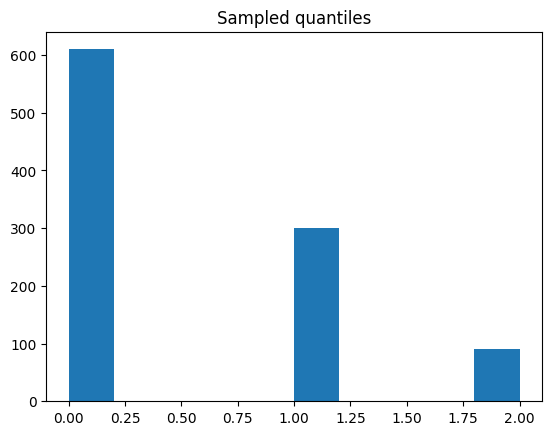

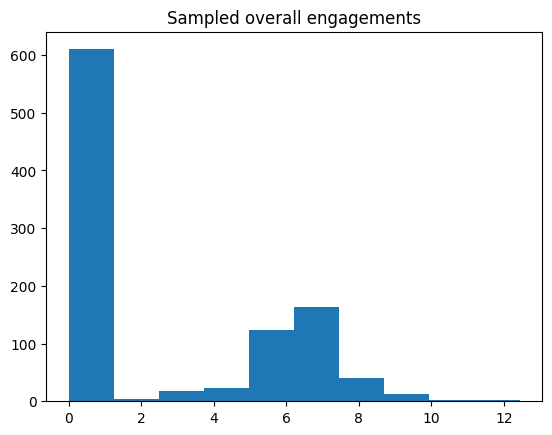

In [22]:
# Tests
sample_quantile_list = []
sample_overall_engagement_list = []
for i in range(1000):
    sample_quantile = draw_quantile([0.6, 0.3, 0.1])
    sample_overall_engagement = draw_overall_engagement(sample_quantile, overall_engagement_tiktok)
    sample_quantile_list.append(sample_quantile)
    sample_overall_engagement_list.append(sample_overall_engagement)
plt.hist(sample_quantile_list)
plt.title("Sampled quantiles")
plt.show()
plt.hist(sample_overall_engagement_list)
plt.title("Sampled overall engagements")
plt.show()

# Multi-armed bandits (Epsilon-greedy vs baseline)

In [23]:
class Bandit:
    # @k_arm: # of arms (3 - FB, Insta, Tiktok)
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @stationary: False, the reward probability distribution changes over time
    # @initial: initial estimation for each action
    def __init__(
        self,
        k_arm=3,
        epsilon=0.0,
        step_size=0.1,
        sample_averages=False,
        stationary=False,
        initial=0.0,
        predicted_probs=[[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25], [0.34, 0.33, 0.33]],
        overall_engagement=[pd.DataFrame(np.zeros((100, 2))) for i in range(3)],
        overall_engagement_quantiles=[pd.DataFrame(np.zeros((4, 1))), pd.DataFrame(np.zeros((4, 1))), pd.DataFrame(np.zeros((3, 1)))],
        overall_engagement_sd=[pd.DataFrame(np.zeros((4, 2))), pd.DataFrame(np.zeros((4, 2))), pd.DataFrame(np.zeros((3, 2)))],
        strategy='epsilon_greedy',
    ):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.epsilon = epsilon
        self.stationary = stationary
        self.initial = initial
        self.predicted_probs_fb = predicted_probs[0]
        self.predicted_probs_insta = predicted_probs[1]
        self.predicted_probs_tiktok = predicted_probs[2]
        self.overall_engagement_fb = overall_engagement[0]
        self.overall_engagement_insta = overall_engagement[1]
        self.overall_engagement_tiktok = overall_engagement[2]
        self.overall_engagement_sd = overall_engagement_sd
        self.overall_engagement_quantiles = overall_engagement_quantiles
        self.strategy = strategy

    # Methods: reset, act, step(action)
    # Resets the bandit, including the real reward distribution, estimation, and action counts.
    def reset(self):
        # reset real reward for each action
        # (recall that this depends on self.stationary)
        # if stationary, different stationary true reward
        # self.q_true = np.random.randn(self.k)
        # if nonstationary, started out same reward

        # Draw sample quantile based on predicted probabilities
        self.quantile = np.array([draw_quantile(self.predicted_probs_fb), 
                                  draw_quantile(self.predicted_probs_insta),
                                  draw_quantile(self.predicted_probs_tiktok)])

        # Draw sample overall engagement based on sample quantile
        # This will be the initial action value
        self.sample_overall_engagement_fb = draw_overall_engagement(self.quantile[0], self.overall_engagement_fb)
        self.sample_overall_engagement_insta = draw_overall_engagement(self.quantile[1], self.overall_engagement_insta)
        self.sample_overall_engagement_tiktok = draw_overall_engagement(self.quantile[2], self.overall_engagement_tiktok)

        self.q_true = np.array([self.sample_overall_engagement_fb, self.sample_overall_engagement_insta, self.sample_overall_engagement_tiktok])

        # reset estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # number of chosen times for each action
        self.action_count = np.zeros(self.k)
        self.time = 0

    # get an action for this bandit based on strategy (epsilon_greedy, predetermined_path)
    def act(self):
        if self.strategy == 'epsilon_greedy':
            # implement the epsilon exploration strategy:
            # with P = epsilon, choose a random action
            if np.random.rand() < self.epsilon:
                # return a random action
                return np.random.choice(self.indices)
            # with P = (1-epsilon), choose best action
            else:
                # Get best action value based on current estimation
                q_best = np.max(self.q_estimation)
                # Choose best action, break ties randomly
                return np.random.choice(np.where(self.q_estimation == q_best)[0])
        else:
            return np.random.choice(np.arange(self.k), p=[0.3,0.6,0.1])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        # np.random.randn() generates random numbers from a standard normal distribution (mean = 0, sd = 1)
        
        # Pick a random number in the range [4.5312, 9.324]
        self.time += 1
        self.action_count[action] += 1

        # Identify the quantile and get the sd
        # print(self.q_true[action])
        self.quantile[action] = get_quantile(self.q_true[action], self.overall_engagement_quantiles[action])
        action_sd = self.overall_engagement_sd[action].iloc[self.quantile[action], 0]

        reward = np.random.uniform(self.q_true[action]-action_sd/2, self.q_true[action]+action_sd/2)
        reward = max(reward, 0)

        # Update true action value
        self.q_true[action] = reward

        if self.sample_averages:
            # update estimation using sample averages
            # Q_{n+1} = Q_{n} + 1/n * (R_{n} − Q_{n})
            self.q_estimation[action] += 1 / self.action_count[action] * (reward - self.q_estimation[action]) 
        else:
            # update estimation with constant step size
            # Q_{n+1} = Q_{n} + alpha * (R_{n} − Q_{n})
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])        
        return reward

def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    actions = np.zeros((len(bandits), runs, time))
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset() # Reset bandit before each run
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                actions[i, r, t] = action
    # Get mean rewards for each (bandit, time); gets average across runs
    mean_rewards = rewards.mean(axis=1)
    return mean_rewards, actions

def epsilon_greedy(predicted_probs_fb, predicted_probs_insta, predicted_probs_tiktok, i, runs=500, time=100):
    epsilons = [0, 0.05, 0.1, 0.15, 0.2]
    bandits = [Bandit(epsilon=eps, step_size=0.1, 
                      predicted_probs=[predicted_probs_fb, predicted_probs_insta, predicted_probs_tiktok],
                      overall_engagement=[overall_engagement_fb, overall_engagement_insta, overall_engagement_tiktok],
                      overall_engagement_quantiles=[overall_engagement_quantiles_fb, overall_engagement_quantiles_insta, overall_engagement_quantiles_tiktok],
                      overall_engagement_sd=overall_engagement_sd,
                      strategy='epsilon_greedy')
                      for eps in epsilons]
    rewards, actions = simulate(runs, time, bandits)
    plt.figure(figsize=(20, 8))
    for eps, reward in zip(epsilons, rewards):
        plt.plot(reward, label="$\epsilon = %.02f$" % (eps))
    plt.xlabel("steps", fontsize=20)
    plt.ylabel("average reward", fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig(f"output/epsilon_greedy_biz_{i}.png")
    plt.close()

    # Get index of best epsilon, defined as the epsilon with the highest average reward at the last time step
    last_reward_epsilon = [rewards_epsilon[-1] for rewards_epsilon in rewards]
    max_reward = max(last_reward_epsilon)
    best_epsilon_index = last_reward_epsilon.index(max_reward)
    best_epsilon = epsilons[best_epsilon_index]
    print(f"Under epsilon-greedy, max reward is {max_reward}, chosen by epsilon = {best_epsilon}")

    # Get the actions of the index of the best epsilon
    best_epsilon_actions = pd.DataFrame(np.hstack(actions[best_epsilon_index]))
    # Get the number of times each action was chosen across all runs and time steps
    best_epsilon_actions_counts = best_epsilon_actions.value_counts().reset_index()
    best_epsilon_actions_counts.columns = ['action', 'count']
    best_epsilon_actions_counts = best_epsilon_actions_counts.sort_values(by='action').reset_index(drop=True)
    # Get the percentage of times each action was chosen across all runs and time steps
    best_epsilon_actions_counts['percentage'] = best_epsilon_actions_counts['count']/best_epsilon_actions_counts['count'].sum()
    # print(best_epsilon_actions_counts)
    return max_reward, best_epsilon_actions_counts

def baseline(predicted_probs_fb, predicted_probs_insta, predicted_probs_tiktok, i, runs=500, time=100):
    bandits = [Bandit(step_size=0.1, 
                      predicted_probs=[predicted_probs_fb, predicted_probs_insta, predicted_probs_tiktok],
                      overall_engagement=[overall_engagement_fb, overall_engagement_insta, overall_engagement_tiktok],
                      overall_engagement_quantiles=[overall_engagement_quantiles_fb, overall_engagement_quantiles_insta, overall_engagement_quantiles_tiktok],
                      overall_engagement_sd=overall_engagement_sd,
                      strategy='predefined_path')]
    rewards, actions = simulate(runs, time, bandits)
    rewards = rewards[0]
    actions = actions[0]
    plt.figure(figsize=(20, 8))
    plt.plot(rewards, label="baseline")
    plt.xlabel("steps", fontsize=20)
    plt.ylabel("average reward", fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig(f"output/baseline_biz_{i}.png")
    plt.close()

    # Get index of best epsilon, defined as the epsilon with the highest average reward at the last time step
    reward = rewards[-1]
    print(f"Under baseline, reward is {reward}")

    # Get the actions of the index of the best epsilon
    actions = pd.DataFrame(np.hstack(actions))
    # Get the number of times each action was chosen across all runs and time steps
    actions_counts = actions.value_counts().reset_index()
    actions_counts.columns = ['action', 'count']
    actions_counts = actions_counts.sort_values(by='action').reset_index(drop=True)
    # Get the percentage of times each action was chosen across all runs and time steps
    actions_counts['percentage'] = actions_counts['count']/actions_counts['count'].sum()
    # print(actions_counts)
    return reward, actions_counts


In [24]:
def main(num_biz, predicted_probs_fb_df, predicted_probs_insta_df, predicted_probs_tiktok_df):
    actions_counts_epsilon_greedy_list = []
    actions_counts_baseline_list = []
    improvement_list = []

    for i in range(num_biz):
        print(f"Business {i+1}")
        # Get predicted probabilities of being in each quantile, for each social media platform
        predicted_probs_fb = predicted_probs_fb_df.iloc[i,:].tolist()
        predicted_probs_insta = predicted_probs_insta_df.iloc[i,:].tolist()
        predicted_probs_tiktok = predicted_probs_tiktok_df.iloc[i,:].tolist()
                
        # Run simulations
        print("Epsilon-greedy:")
        reward_epsilon_greedy, actions_counts_epsilon_greedy = epsilon_greedy(predicted_probs_fb, predicted_probs_insta, predicted_probs_tiktok, i)
        print("Baseline:")
        reward_baseline, action_counts_baseline = baseline(predicted_probs_fb, predicted_probs_insta, predicted_probs_tiktok, i)
        
        # Record actions
        actions_counts_epsilon_greedy_list.append(actions_counts_epsilon_greedy)
        actions_counts_baseline_list.append(action_counts_baseline)

        # Record % improvement
        improvement = (reward_epsilon_greedy-reward_baseline)/reward_baseline*100
        print("% improvement:", improvement, "\n")
        improvement_list.append(improvement)

    return actions_counts_epsilon_greedy_list, actions_counts_baseline_list, improvement_list

In [25]:
# Run main loop
actions_counts_epsilon_greedy_list, actions_counts_baseline_list, improvement_list = main(num_biz, predicted_probs_fb_df, predicted_probs_insta_df, predicted_probs_tiktok_df)

Business 1
Epsilon-greedy:


100%|██████████| 500/500 [00:08<00:00, 57.83it/s]


Under epsilon-greedy, max reward is 6.4893090314026365, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:09<00:00, 51.72it/s]


Under baseline, reward is 4.831429756945883
% improvement: 34.31446503125314 

Business 2
Epsilon-greedy:


100%|██████████| 500/500 [00:08<00:00, 55.73it/s]


Under epsilon-greedy, max reward is 7.535151450507555, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:13<00:00, 37.79it/s]


Under baseline, reward is 5.3799114796084675
% improvement: 40.060881653315576 

Business 3
Epsilon-greedy:


100%|██████████| 500/500 [00:08<00:00, 61.14it/s]


Under epsilon-greedy, max reward is 6.335850190308798, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:10<00:00, 49.91it/s]


Under baseline, reward is 4.60182966732282
% improvement: 37.681110522171274 

Business 4
Epsilon-greedy:


100%|██████████| 500/500 [00:08<00:00, 59.81it/s]


Under epsilon-greedy, max reward is 6.210760525316861, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:11<00:00, 45.22it/s]


Under baseline, reward is 4.247162431663777
% improvement: 46.233176273502366 

Business 5
Epsilon-greedy:


100%|██████████| 500/500 [00:08<00:00, 60.10it/s]


Under epsilon-greedy, max reward is 6.7338365868210275, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:09<00:00, 50.65it/s]


Under baseline, reward is 5.971855323404112
% improvement: 12.759539910999825 

Business 6
Epsilon-greedy:


100%|██████████| 500/500 [00:09<00:00, 52.12it/s]


Under epsilon-greedy, max reward is 6.0727803363351365, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:09<00:00, 52.50it/s]


Under baseline, reward is 4.707547493968604
% improvement: 29.00093613746211 

Business 7
Epsilon-greedy:


100%|██████████| 500/500 [00:09<00:00, 51.66it/s]


Under epsilon-greedy, max reward is 6.91821303639164, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:10<00:00, 48.21it/s]


Under baseline, reward is 6.007551155714466
% improvement: 15.158620493991798 

Business 8
Epsilon-greedy:


100%|██████████| 500/500 [00:09<00:00, 50.58it/s]


Under epsilon-greedy, max reward is 6.3800898029952045, chosen by epsilon = 0.05
Baseline:


100%|██████████| 500/500 [00:10<00:00, 45.91it/s]


Under baseline, reward is 4.596414731268945
% improvement: 38.8057905130296 

Business 9
Epsilon-greedy:


100%|██████████| 500/500 [00:10<00:00, 48.84it/s]


Under epsilon-greedy, max reward is 6.498931368699359, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:11<00:00, 44.91it/s]


Under baseline, reward is 4.770609146686575
% improvement: 36.22854375343638 

Business 10
Epsilon-greedy:


100%|██████████| 500/500 [00:09<00:00, 51.23it/s]


Under epsilon-greedy, max reward is 6.797365040388125, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:09<00:00, 50.29it/s]


Under baseline, reward is 5.746551218837422
% improvement: 18.28599070179856 

Business 11
Epsilon-greedy:


100%|██████████| 500/500 [00:10<00:00, 45.97it/s]


Under epsilon-greedy, max reward is 6.563170170193842, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:10<00:00, 45.69it/s]


Under baseline, reward is 5.0885052125531995
% improvement: 28.980317323890816 

Business 12
Epsilon-greedy:


100%|██████████| 500/500 [00:10<00:00, 47.25it/s]


Under epsilon-greedy, max reward is 7.165015383278236, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:10<00:00, 49.89it/s]


Under baseline, reward is 5.3828578485423835
% improvement: 33.10801780170436 

Business 13
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.67it/s]


Under epsilon-greedy, max reward is 6.9456722691461685, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:09<00:00, 52.65it/s]


Under baseline, reward is 4.980536820277282
% improvement: 39.456297981137716 

Business 14
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.34it/s]


Under epsilon-greedy, max reward is 7.227944878299051, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 95.34it/s]


Under baseline, reward is 6.393825565965322
% improvement: 13.04570016382353 

Business 15
Epsilon-greedy:


100%|██████████| 500/500 [00:06<00:00, 72.36it/s]


Under epsilon-greedy, max reward is 6.348353057254289, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 90.65it/s]


Under baseline, reward is 4.519046896387547
% improvement: 40.47991098142973 

Business 16
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.77it/s]


Under epsilon-greedy, max reward is 6.568872460697028, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 94.53it/s]


Under baseline, reward is 5.730083883759522
% improvement: 14.638329803771994 

Business 17
Epsilon-greedy:


100%|██████████| 500/500 [00:06<00:00, 80.55it/s]


Under epsilon-greedy, max reward is 6.604473688991837, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:07<00:00, 63.87it/s]


Under baseline, reward is 4.834490311531033
% improvement: 36.61158185050265 

Business 18
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.01it/s]


Under epsilon-greedy, max reward is 7.085115444637516, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 95.22it/s]


Under baseline, reward is 6.050059360251519
% improvement: 17.108197172183885 

Business 19
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 92.67it/s]


Under epsilon-greedy, max reward is 7.218486331828589, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 84.85it/s]


Under baseline, reward is 5.6088608602997745
% improvement: 28.697903399992448 

Business 20
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 92.75it/s]


Under epsilon-greedy, max reward is 7.137434191882367, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 65.99it/s]


Under baseline, reward is 5.931395434140685
% improvement: 20.333136968070097 

Business 21
Epsilon-greedy:


100%|██████████| 500/500 [00:07<00:00, 67.47it/s]


Under epsilon-greedy, max reward is 7.229366817382117, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 65.96it/s]


Under baseline, reward is 6.104077422305735
% improvement: 18.435044597637486 

Business 22
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 84.33it/s]


Under epsilon-greedy, max reward is 5.83405877460672, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 78.18it/s]


Under baseline, reward is 4.475181401764818
% improvement: 30.36474392537517 

Business 23
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.96it/s]


Under epsilon-greedy, max reward is 6.529078251293197, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 84.72it/s]


Under baseline, reward is 5.692372144265527
% improvement: 14.698724641019195 

Business 24
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.31it/s]


Under epsilon-greedy, max reward is 6.121397268082698, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 93.65it/s]


Under baseline, reward is 4.556427902010378
% improvement: 34.346409067107764 

Business 25
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.18it/s]


Under epsilon-greedy, max reward is 6.533771474814822, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 92.56it/s]


Under baseline, reward is 5.623538887866764
% improvement: 16.186117053657398 

Business 26
Epsilon-greedy:


100%|██████████| 500/500 [00:06<00:00, 81.09it/s]


Under epsilon-greedy, max reward is 6.237820298591918, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 77.62it/s]


Under baseline, reward is 4.972822677265856
% improvement: 25.438220974763965 

Business 27
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.84it/s]


Under epsilon-greedy, max reward is 6.561223832151166, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 92.15it/s]


Under baseline, reward is 5.481643857788206
% improvement: 19.694456669765493 

Business 28
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.99it/s]


Under epsilon-greedy, max reward is 6.719793627841002, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 94.86it/s]


Under baseline, reward is 6.020118174793661
% improvement: 11.62228768160888 

Business 29
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 85.20it/s]


Under epsilon-greedy, max reward is 6.310442788650061, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 92.67it/s]


Under baseline, reward is 4.272829874176892
% improvement: 47.68766776294105 

Business 30
Epsilon-greedy:


100%|██████████| 500/500 [00:06<00:00, 80.09it/s]


Under epsilon-greedy, max reward is 6.273805749553307, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:08<00:00, 59.28it/s]


Under baseline, reward is 4.809261338793149
% improvement: 30.452585284701428 

Business 31
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.04it/s]


Under epsilon-greedy, max reward is 7.278627486803253, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 85.23it/s]


Under baseline, reward is 4.97589947106047
% improvement: 46.27762335503983 

Business 32
Epsilon-greedy:


100%|██████████| 500/500 [00:07<00:00, 67.60it/s]


Under epsilon-greedy, max reward is 6.451470714110388, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:07<00:00, 68.97it/s]


Under baseline, reward is 4.847469889479901
% improvement: 33.08944379647473 

Business 33
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 92.28it/s]


Under epsilon-greedy, max reward is 7.334264633920957, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:08<00:00, 55.89it/s]


Under baseline, reward is 5.414729044385378
% improvement: 35.450261200529994 

Business 34
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.02it/s]


Under epsilon-greedy, max reward is 5.981120040289655, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 84.53it/s]


Under baseline, reward is 4.749243537096678
% improvement: 25.938372997103688 

Business 35
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 93.13it/s]


Under epsilon-greedy, max reward is 6.594671953655153, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 66.19it/s]


Under baseline, reward is 5.864842610275104
% improvement: 12.44414201502016 

Business 36
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.16it/s]


Under epsilon-greedy, max reward is 6.273689702736082, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:09<00:00, 54.61it/s]


Under baseline, reward is 5.0626509968666875
% improvement: 23.921038732847975 

Business 37
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.46it/s]


Under epsilon-greedy, max reward is 6.64250229960341, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:09<00:00, 54.93it/s]


Under baseline, reward is 5.288513365202176
% improvement: 25.602448947379596 

Business 38
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.61it/s]


Under epsilon-greedy, max reward is 7.061796152895339, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 84.18it/s]


Under baseline, reward is 6.250904486893618
% improvement: 12.972389319048661 

Business 39
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.39it/s]


Under epsilon-greedy, max reward is 6.3288369839812, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 95.28it/s]


Under baseline, reward is 5.4099682821426365
% improvement: 16.984733623514757 

Business 40
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.62it/s]


Under epsilon-greedy, max reward is 6.908269722633739, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 95.95it/s]


Under baseline, reward is 6.187375677638918
% improvement: 11.651046947094578 

Business 41
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.69it/s]


Under epsilon-greedy, max reward is 6.894858594528488, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:07<00:00, 69.59it/s]


Under baseline, reward is 5.919804402908363
% improvement: 16.47105419802531 

Business 42
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.52it/s]


Under epsilon-greedy, max reward is 6.780489148791185, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 81.63it/s]


Under baseline, reward is 5.426870943243833
% improvement: 24.942885498917832 

Business 43
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 91.31it/s]


Under epsilon-greedy, max reward is 6.4006312424140495, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 69.66it/s]


Under baseline, reward is 5.096418866841339
% improvement: 25.590761074570693 

Business 44
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.68it/s]


Under epsilon-greedy, max reward is 5.984212762919168, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:07<00:00, 70.52it/s]


Under baseline, reward is 4.3798843133869605
% improvement: 36.62947088873181 

Business 45
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.01it/s]


Under epsilon-greedy, max reward is 6.366857187958815, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 95.15it/s]


Under baseline, reward is 4.44954114901625
% improvement: 43.090196825496605 

Business 46
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 93.27it/s]


Under epsilon-greedy, max reward is 7.224939954926179, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:08<00:00, 56.50it/s]


Under baseline, reward is 6.18819642666792
% improvement: 16.753565284230984 

Business 47
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 88.42it/s]


Under epsilon-greedy, max reward is 7.342374358661535, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:06<00:00, 73.99it/s]


Under baseline, reward is 5.135136109985695
% improvement: 42.98305247223501 

Business 48
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.82it/s]


Under epsilon-greedy, max reward is 6.0749515882247955, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 87.92it/s]


Under baseline, reward is 4.595040589615287
% improvement: 32.20670132825555 

Business 49
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.60it/s]


Under epsilon-greedy, max reward is 5.820004655087106, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 86.48it/s]


Under baseline, reward is 4.420431734196001
% improvement: 31.66145311246761 

Business 50
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.06it/s]


Under epsilon-greedy, max reward is 6.450466450689237, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:06<00:00, 75.84it/s]


Under baseline, reward is 5.150330828793799
% improvement: 25.24373025955553 

Business 51
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.03it/s]


Under epsilon-greedy, max reward is 6.589419763914168, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:06<00:00, 75.80it/s]


Under baseline, reward is 4.686445850830809
% improvement: 40.60590847851151 

Business 52
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 93.36it/s]


Under epsilon-greedy, max reward is 6.503181282027719, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 81.92it/s]


Under baseline, reward is 5.686676759268956
% improvement: 14.35820176393721 

Business 53
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.91it/s]


Under epsilon-greedy, max reward is 6.705686117949517, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:07<00:00, 68.36it/s]


Under baseline, reward is 5.770252943468225
% improvement: 16.211302756496632 

Business 54
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.50it/s]


Under epsilon-greedy, max reward is 6.451133726583546, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 78.00it/s]


Under baseline, reward is 4.901365258091796
% improvement: 31.619118080073612 

Business 55
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 97.03it/s]


Under epsilon-greedy, max reward is 6.351189330548512, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 86.13it/s]


Under baseline, reward is 4.546834789126757
% improvement: 39.68374979747812 

Business 56
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.94it/s]


Under epsilon-greedy, max reward is 6.355691642836519, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 87.72it/s]


Under baseline, reward is 4.554532811887273
% improvement: 39.54651125244382 

Business 57
Epsilon-greedy:


100%|██████████| 500/500 [00:08<00:00, 57.39it/s]


Under epsilon-greedy, max reward is 6.151947637042803, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:06<00:00, 80.06it/s]


Under baseline, reward is 4.569869817982621
% improvement: 34.61975684372108 

Business 58
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.99it/s]


Under epsilon-greedy, max reward is 6.227459325590282, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:06<00:00, 72.23it/s]


Under baseline, reward is 4.381520498976026
% improvement: 42.13009677908977 

Business 59
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.96it/s]


Under epsilon-greedy, max reward is 6.413123393600866, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:08<00:00, 57.71it/s]


Under baseline, reward is 4.741246636301733
% improvement: 35.26238741723063 

Business 60
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.88it/s]


Under epsilon-greedy, max reward is 6.371691122352768, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 69.64it/s]


Under baseline, reward is 4.577982079149039
% improvement: 39.18121591985668 

Business 61
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 92.84it/s]


Under epsilon-greedy, max reward is 6.396020727624573, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:09<00:00, 53.09it/s]


Under baseline, reward is 5.3763078346647575
% improvement: 18.966787697404985 

Business 62
Epsilon-greedy:


100%|██████████| 500/500 [00:06<00:00, 82.04it/s]


Under epsilon-greedy, max reward is 7.361009045778344, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 65.85it/s]


Under baseline, reward is 5.868896039001011
% improvement: 25.42408311310481 

Business 63
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.51it/s]


Under epsilon-greedy, max reward is 6.375825056256763, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:08<00:00, 56.54it/s]


Under baseline, reward is 5.293640356604847
% improvement: 20.44310959473625 

Business 64
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.19it/s]


Under epsilon-greedy, max reward is 6.355765806235045, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:06<00:00, 81.93it/s]


Under baseline, reward is 4.9444426147217815
% improvement: 28.54362567200463 

Business 65
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 97.19it/s]


Under epsilon-greedy, max reward is 7.7226566696878916, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 84.28it/s]


Under baseline, reward is 6.047566649807247
% improvement: 27.698578897580806 

Business 66
Epsilon-greedy:


100%|██████████| 500/500 [00:06<00:00, 71.61it/s]


Under epsilon-greedy, max reward is 6.296166298487895, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 95.44it/s]


Under baseline, reward is 5.132985087283181
% improvement: 22.660911563652522 

Business 67
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.31it/s]


Under epsilon-greedy, max reward is 6.237042124970355, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 92.02it/s]


Under baseline, reward is 4.561839010506492
% improvement: 36.722100683642246 

Business 68
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 93.41it/s]


Under epsilon-greedy, max reward is 6.14139670900672, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:08<00:00, 56.42it/s]


Under baseline, reward is 4.668799084231512
% improvement: 31.541250720100294 

Business 69
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 97.01it/s]


Under epsilon-greedy, max reward is 6.419497125307441, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 93.53it/s]


Under baseline, reward is 5.010546225299207
% improvement: 28.119706647833553 

Business 70
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.43it/s]


Under epsilon-greedy, max reward is 7.3086760820890575, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 78.87it/s]


Under baseline, reward is 6.197980825335097
% improvement: 17.920275781006627 

Business 71
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.83it/s]


Under epsilon-greedy, max reward is 6.2210455446458885, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:23<00:00, 20.97it/s]


Under baseline, reward is 4.9395713865429425
% improvement: 25.943023348019906 

Business 72
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.77it/s]


Under epsilon-greedy, max reward is 6.543451865175507, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 94.46it/s]


Under baseline, reward is 5.597949359105754
% improvement: 16.890158260038156 

Business 73
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.03it/s]


Under epsilon-greedy, max reward is 6.489891047258225, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 83.57it/s]


Under baseline, reward is 4.975666617970734
% improvement: 30.432594173784288 

Business 74
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.94it/s]


Under epsilon-greedy, max reward is 6.039827222297317, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:07<00:00, 62.74it/s]


Under baseline, reward is 4.326040740593738
% improvement: 39.61558812015178 

Business 75
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 92.81it/s]


Under epsilon-greedy, max reward is 5.959651637723469, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:06<00:00, 82.87it/s]


Under baseline, reward is 4.505689828500215
% improvement: 32.269460716678445 

Business 76
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 94.49it/s]


Under epsilon-greedy, max reward is 7.055535597202399, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 71.90it/s]


Under baseline, reward is 5.984347015921773
% improvement: 17.89984067485817 

Business 77
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.53it/s]


Under epsilon-greedy, max reward is 7.1128148253662955, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 85.23it/s]


Under baseline, reward is 5.639377275439837
% improvement: 26.127664065737466 

Business 78
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.76it/s]


Under epsilon-greedy, max reward is 6.712192173541825, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 69.58it/s]


Under baseline, reward is 4.936164257714395
% improvement: 35.979919287568215 

Business 79
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 93.91it/s]


Under epsilon-greedy, max reward is 7.034363714025386, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 63.26it/s]


Under baseline, reward is 6.290264578397303
% improvement: 11.82937738713802 

Business 80
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.71it/s]


Under epsilon-greedy, max reward is 7.192789354436992, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:06<00:00, 71.58it/s]


Under baseline, reward is 6.083023721934719
% improvement: 18.243651237140167 

Business 81
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.57it/s]


Under epsilon-greedy, max reward is 6.429837721452824, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:07<00:00, 68.88it/s]


Under baseline, reward is 5.518770305897164
% improvement: 16.508522099245997 

Business 82
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.39it/s]


Under epsilon-greedy, max reward is 7.393055420173277, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:06<00:00, 83.21it/s]


Under baseline, reward is 5.337852373685222
% improvement: 38.502433237379975 

Business 83
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.78it/s]


Under epsilon-greedy, max reward is 6.460685925846906, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 85.06it/s]


Under baseline, reward is 4.899143148024529
% improvement: 31.87379365414203 

Business 84
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.87it/s]


Under epsilon-greedy, max reward is 6.75418379178049, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 87.52it/s]


Under baseline, reward is 5.064768535466036
% improvement: 33.35621844284346 

Business 85
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.96it/s]


Under epsilon-greedy, max reward is 6.030300477780135, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:05<00:00, 93.41it/s]


Under baseline, reward is 4.474460791196775
% improvement: 34.77155704759729 

Business 86
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.82it/s]


Under epsilon-greedy, max reward is 7.033318571244003, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 93.39it/s]


Under baseline, reward is 5.143063629851203
% improvement: 36.75348153231944 

Business 87
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.51it/s]


Under epsilon-greedy, max reward is 6.074004433794295, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:06<00:00, 77.80it/s]


Under baseline, reward is 4.404531399918126
% improvement: 37.90353348161402 

Business 88
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.18it/s]


Under epsilon-greedy, max reward is 6.469814979083829, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:05<00:00, 94.14it/s]


Under baseline, reward is 4.86786842391123
% improvement: 32.9085837099407 

Business 89
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.51it/s]


Under epsilon-greedy, max reward is 6.761576497260694, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 92.33it/s]


Under baseline, reward is 4.758667576788769
% improvement: 42.089700281681004 

Business 90
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 95.85it/s]


Under epsilon-greedy, max reward is 6.638570754979738, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:08<00:00, 59.88it/s]


Under baseline, reward is 4.963223396199553
% improvement: 33.75522770268681 

Business 91
Epsilon-greedy:


100%|██████████| 500/500 [00:08<00:00, 57.04it/s]


Under epsilon-greedy, max reward is 6.156442201068794, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:08<00:00, 58.01it/s]


Under baseline, reward is 4.263341029013398
% improvement: 44.40416938669078 

Business 92
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 96.00it/s]


Under epsilon-greedy, max reward is 7.272986471300031, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:07<00:00, 62.97it/s]


Under baseline, reward is 6.253890962931685
% improvement: 16.295383376665352 

Business 93
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 84.66it/s]


Under epsilon-greedy, max reward is 6.122358588611458, chosen by epsilon = 0.2
Baseline:


100%|██████████| 500/500 [00:06<00:00, 72.25it/s]


Under baseline, reward is 5.017607069231531
% improvement: 22.017497666454886 

Business 94
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 97.14it/s]


Under epsilon-greedy, max reward is 6.806038087741731, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:06<00:00, 75.65it/s]


Under baseline, reward is 5.1059238085668435
% improvement: 33.29689871835523 

Business 95
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 97.05it/s]


Under epsilon-greedy, max reward is 6.230082252007719, chosen by epsilon = 0.1
Baseline:


100%|██████████| 500/500 [00:05<00:00, 84.64it/s]


Under baseline, reward is 4.3770588872454015
% improvement: 42.33489684504734 

Business 96
Epsilon-greedy:


100%|██████████| 500/500 [00:05<00:00, 85.45it/s]


Under epsilon-greedy, max reward is 6.021729051427741, chosen by epsilon = 0.15
Baseline:


100%|██████████| 500/500 [00:08<00:00, 58.02it/s]


Under baseline, reward is 4.5089390435821315
% improvement: 33.55090838938846 



# Plot results

## Improvement in overall engagement scores

median improvement: 30.39866904957973


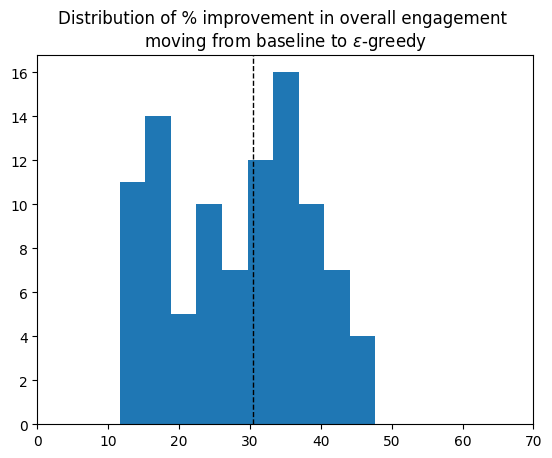

In [26]:
# Show improvement
plt.hist(improvement_list)
plt.xlim(0, 70)

# Plot the median as a vertical line and label it with the mean
plt.axvline(np.median(improvement_list), color='k', linestyle='dashed', linewidth=1)
plt.title("Distribution of % improvement in overall engagement \nmoving from baseline to $\epsilon$-greedy")
print("median improvement:", np.median(improvement_list))
plt.savefig("output/improvement_hist.png")

## Differences in action counts

In [27]:
# Get total counts of each actions across all businesses
actions_counts_epsilon_greedy_total = pd.concat(actions_counts_epsilon_greedy_list).groupby('action')['count'].sum().reset_index()
actions_counts_epsilon_greedy_total = actions_counts_epsilon_greedy_total.rename(columns={'count': 'count_epsilon_greedy'})
actions_counts_baseline_total = pd.concat(actions_counts_baseline_list).groupby('action')['count'].sum().reset_index()
actions_counts_baseline_total = actions_counts_baseline_total.rename(columns={'count': 'count_baseline'})
actions_counts_total = pd.concat([actions_counts_epsilon_greedy_total, actions_counts_baseline_total['count_baseline']], axis=1)

# Rename 0, 1, 2 to FB, Insta, Tiktok
actions_counts_total['action'] = actions_counts_total['action'].replace(0, 'FB')
actions_counts_total['action'] = actions_counts_total['action'].replace(1, 'Insta')
actions_counts_total['action'] = actions_counts_total['action'].replace(2, 'Tiktok')

# Get overall % difference
actions_counts_total['pct_difference'] = (actions_counts_total['count_epsilon_greedy']-actions_counts_total['count_baseline'])/actions_counts_total['count_baseline']*100
actions_counts_total

,action,count_epsilon_greedy,count_baseline,pct_difference
0,FB,1178304,1440390,-18.195489
1,Insta,2410472,2879619,-16.291982
2,Tiktok,1211224,479991,152.343065


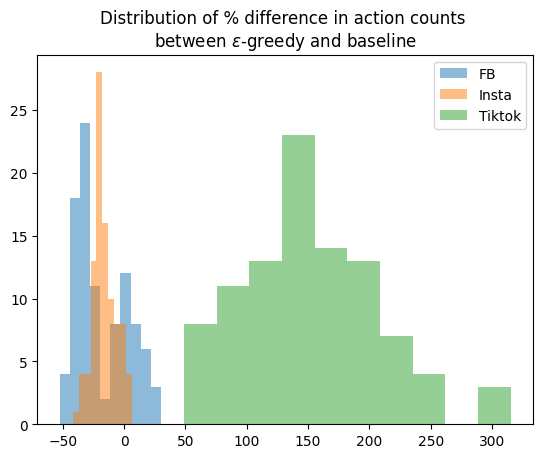

In [28]:
# Show changes in actions
actions_counts_pct_difference_list = []
for i in range(num_biz):
    actions_counts_epsilon_greedy_i = actions_counts_epsilon_greedy_list[i]
    actions_counts_baseline_i = actions_counts_baseline_list[i]
    actions_counts_pct_difference = (actions_counts_epsilon_greedy_i['count']-actions_counts_baseline_i['count'])/actions_counts_baseline_i['count']*100
    actions_counts_pct_difference_list.append(actions_counts_pct_difference)

actions_counts_pct_difference_df = pd.concat(actions_counts_pct_difference_list, axis=1)

plt.hist(actions_counts_pct_difference_df.iloc[0,:], alpha=0.5, label='FB')
plt.hist(actions_counts_pct_difference_df.iloc[1,:], alpha=0.5, label='Insta')
plt.hist(actions_counts_pct_difference_df.iloc[2,:], alpha=0.5, label='Tiktok')
plt.title("Distribution of % difference in action counts \nbetween $\epsilon$-greedy and baseline")
plt.legend()
plt.savefig("output/action_counts_pct_difference.png")
plt.show()